# Unegui Laptop Listing Machine Learning

In [531]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import *
from catboost import CatBoostRegressor

In [394]:
df = pd.read_csv('finaldf.csv')

## Data Cleaning

In [395]:
df.isnull().sum()

manufacturer        0
condition           0
price               0
screen size         0
processor         517
ram               384
disk size         959
graphics card    3600
description         0
dtype: int64

Due to the big variability in graphics card names, let's drop the mostly null graphics card column and the description column, as it's not useful.

In [396]:
df = df.drop(['graphics card','description'], axis=1)

In [397]:
df = df.dropna()

In [398]:
df

manufacturer condition    price    screen size processor    ram disk size
0              HP       New  3800000    16'' - 17''        i9   16GB       1TB
1            Asus       New  3500000  15'' - 15,6''        m2   32gb     512gb
3            Acer       New  2200000  15'' - 15,6''        i5    8GB     512GB
5            Asus       New  3950000    16'' - 17''        i9  16 GB       1TB
6             MSI       New  3000000  15'' - 15,6''        i5    8GB     256GB
...           ...       ...      ...            ...       ...    ...       ...
4793         Dell      Used  1790000    13'' - 14''        i5    8GB     256GB
4794       Lenovo      Used  2590000  15'' - 15,6''        i7   16GB     512GB
4795         Acer      Used  3890000  15'' - 15,6''   Ryzen 7   16GB       1TB
4796         Acer      Used  4690000  15'' - 15,6''        i9   16GB     512GB
4797       Lenovo      Used  1990000    13'' - 14''        i5    8GB     256GB

[3579 rows x 7 columns]

In [399]:
len(df)

3579

In [400]:
df = df.reset_index(drop=True)

### Let's format and unify the columns

Let's convert columns ram and disk size into integers.

In [401]:
df['ram'] = df['ram'].str.extract('(\d+)', expand=False).astype(int)

In [402]:
df['disk size'] = df['disk size'].str.extract('(\d+)', expand=False).astype(int)

In [403]:
for i in range(len(df)):
    if df['disk size'][i] < 5:
        df['disk size'][i] = df['disk size'][i] * 1024

<ipython-input-403-4443daf5ccc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disk size'][i] = df['disk size'][i] * 1024
<ipython-input-403-4443daf5ccc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disk size'][i] = df['disk size'][i] * 1024
<ipython-input-403-4443daf5ccc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disk size'][i] = df['disk size'][i] * 1024
<ipython-input-403-4443daf5ccc8>:3: SettingWithCopyW

In [404]:
df

manufacturer condition    price    screen size processor  ram  disk size
0              HP       New  3800000    16'' - 17''        i9   16       1024
1            Asus       New  3500000  15'' - 15,6''        m2   32        512
2            Acer       New  2200000  15'' - 15,6''        i5    8        512
3            Asus       New  3950000    16'' - 17''        i9   16       1024
4             MSI       New  3000000  15'' - 15,6''        i5    8        256
...           ...       ...      ...            ...       ...  ...        ...
3574         Dell      Used  1790000    13'' - 14''        i5    8        256
3575       Lenovo      Used  2590000  15'' - 15,6''        i7   16        512
3576         Acer      Used  3890000  15'' - 15,6''   Ryzen 7   16       1024
3577         Acer      Used  4690000  15'' - 15,6''        i9   16        512
3578       Lenovo      Used  1990000    13'' - 14''        i5    8        256

[3579 rows x 7 columns]

In [405]:
df['disk size'].value_counts()

disk size
256     1885
128      823
512      729
1024     141
2048       1
Name: count, dtype: int64

In [406]:
df['ram'].value_counts()

ram
8     2367
16     697
4      502
32      12
64       1
Name: count, dtype: int64

In [407]:
df['screen size'].value_counts()

screen size
15'' - 15,6''    1890
13'' - 14''      1494
16'' - 17''       100
13" хүртэл         92
18"-ээс дээш        3
Name: count, dtype: int64

Let's enumerate the column, so the bigger screen size category gets a bigger number. But first, let's remove " and ' signs first.

In [408]:
for i in range(len(df)):
    df['screen size'][i] = df['screen size'][i].replace("'", "")

<ipython-input-408-cede6a681991>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['screen size'][i] = df['screen size'][i].replace("'", "")
<ipython-input-408-cede6a681991>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['screen size'][i] = df['screen size'][i].replace("'", "")
<ipython-input-408-cede6a681991>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['screen size'][i] = df['screen size'][i].replace("'", "")
<ipython-i

In [409]:
for i in range(len(df)):
    df['screen size'][i] = df['screen size'][i].replace('"', "")

<ipython-input-409-3c7a2f3ad81f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['screen size'][i] = df['screen size'][i].replace('"', "")
<ipython-input-409-3c7a2f3ad81f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['screen size'][i] = df['screen size'][i].replace('"', "")
<ipython-input-409-3c7a2f3ad81f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['screen size'][i] = df['screen size'][i].replace('"', "")
<ipython-i

In [410]:
df['screen size'].value_counts()

screen size
15 - 15,6      1890
13 - 14        1494
16 - 17         100
13 хүртэл        92
18-ээс дээш       3
Name: count, dtype: int64

In [411]:
replacement = {'13 хүртэл':'0',
               '13 - 14':'1',
               '15 - 15,6':'2',
               '16 - 17':'3',
               '18-ээс дээш':'4'}

In [412]:
df['screen size'] = df['screen size'].replace(replacement)

Let's do the same for the manufacturer column, but we need to find the mean price of each manufacturer.

In [413]:
mean_prices_manufacturer = df.groupby('manufacturer')['price'].mean().reset_index()

In [414]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [415]:
mean_prices_manufacturer = mean_prices_manufacturer.sort_values(by='price')

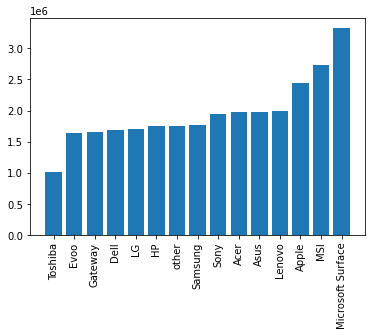

In [416]:
plt.bar(mean_prices_manufacturer['manufacturer'], mean_prices_manufacturer['price'])
plt.xticks(rotation=90);

In [417]:
mean_prices_manufacturer.reset_index(drop=True)

manufacturer      price
0             Toshiba 1012857.14
1                Evoo 1646666.67
2             Gateway 1660952.38
3                Dell 1691397.28
4                  LG 1710000.00
5                  HP 1751318.70
6               other 1752941.18
7             Samsung 1773000.00
8                Sony 1950000.00
9                Acer 1971842.07
10               Asus 1984345.53
11             Lenovo 1985370.34
12              Apple 2439499.98
13                MSI 2732187.50
14  Microsoft Surface 3326285.71

In [418]:
make_cat = list(mean_prices_manufacturer['manufacturer'])

In [419]:
df['manufacturer'] = pd.Categorical(df['manufacturer'], categories=make_cat, ordered=True)

In [420]:
df['manufacturer'].cat.categories

Index(['Toshiba', 'Evoo', 'Gateway', 'Dell', 'LG', 'HP', 'other', 'Samsung',
       'Sony', 'Acer', 'Asus', 'Lenovo', 'Apple', 'MSI', 'Microsoft Surface'],
      dtype='object')

In [421]:
df['manufacturer'] = df['manufacturer'].cat.codes

### Let's numerate the 'condition' column

In [422]:
for i in range(len(df)):
    if df['condition'][i] == 'New':
        df['condition'][i] = df['condition'][i].replace('New', "1")
    elif df['condition'][i] == 'Used':
        df['condition'][i] = df['condition'][i].replace('Used', "0")

<ipython-input-422-1d5b730576dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['condition'][i] = df['condition'][i].replace('New', "1")
<ipython-input-422-1d5b730576dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['condition'][i] = df['condition'][i].replace('New', "1")
<ipython-input-422-1d5b730576dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['condition'][i] = df['condition'][i].replace('New', "1")
<ipython-inpu

In [423]:
df['condition'].value_counts()

condition
1    1972
0    1607
Name: count, dtype: int64

### Let's enumerate the 'processor' column

In [424]:
df['processor'].value_counts()

processor
i5         1645
i7          772
M2          229
Ryzen 3     174
Ryzen 5     140
i3          128
m2          105
Ryzen5       76
I5           76
I7           64
M1           58
Ryzen 7      34
I3           13
M3           10
ryzen 3       8
i9            8
Celeron       7
RYZEN 3       6
RYZEN 5       5
m1            4
Ryzen7        3
ryzen5        3
ryzen 5       2
Ryzen9        2
Ryzen 9       2
CELERON       2
I9            1
ryzen 7       1
m3            1
Name: count, dtype: int64

In [425]:
for i in range(len(df)):
    df['processor'][i] = df['processor'][i].replace(' ', "")

<ipython-input-425-cd6a593d3c96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processor'][i] = df['processor'][i].replace(' ', "")
<ipython-input-425-cd6a593d3c96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processor'][i] = df['processor'][i].replace(' ', "")
<ipython-input-425-cd6a593d3c96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processor'][i] = df['processor'][i].replace(' ', "")
<ipython-input-425-cd6

In [426]:
df['processor'] = df['processor'].str.lower()

In [427]:
df['processor'].value_counts()

processor
i5         1721
i7          836
m2          334
ryzen5      226
ryzen3      188
i3          141
m1           62
ryzen7       38
m3           11
i9            9
celeron       9
ryzen9        4
Name: count, dtype: int64

In [428]:
mean_prices_cpu = df.groupby('processor')['price'].mean().reset_index()

In [429]:
mean_prices_cpu = mean_prices_cpu.sort_values(by='price')

In [430]:
mean_prices_cpu

processor      price
0    celeron  778888.89
1         i3 1308014.18
8     ryzen3 1461436.17
7         m3 1652727.27
2         i5 1739386.96
6         m2 1884101.69
9     ryzen5 2165973.42
3         i7 2232547.83
10    ryzen7 2791842.11
5         m1 3028387.10
11    ryzen9 3735000.00
4         i9 4747777.78

In [431]:
make_cat = list(mean_prices_cpu['processor'])

In [432]:
df['processor'] = pd.Categorical(df['processor'], categories=make_cat, ordered=True)

In [433]:
df['processor'].cat.categories

Index(['celeron', 'i3', 'ryzen3', 'm3', 'i5', 'm2', 'ryzen5', 'i7', 'ryzen7',
       'm1', 'ryzen9', 'i9'],
      dtype='object')

In [434]:
df['processor'] = df['processor'].cat.codes

In [435]:
df

manufacturer condition    price screen size  processor  ram  disk size
0                5         1  3800000           3         11   16       1024
1               10         1  3500000           2          5   32        512
2                9         1  2200000           2          4    8        512
3               10         1  3950000           3         11   16       1024
4               13         1  3000000           2          4    8        256
...            ...       ...      ...         ...        ...  ...        ...
3574             3         0  1790000           1          4    8        256
3575            11         0  2590000           2          7   16        512
3576             9         0  3890000           2          8   16       1024
3577             9         0  4690000           2         11   16        512
3578            11         0  1990000           1          4    8        256

[3579 rows x 7 columns]

In [449]:
df.dtypes

manufacturer      int8
condition       object
price            int64
screen size     object
processor         int8
ram              int32
disk size        int32
dtype: object

In [450]:
df['condition'] = df['condition'].astype(int)
df['screen size'] = df['screen size'].astype(int)

## Some Data Analysis

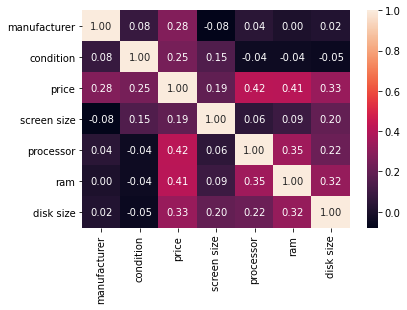

In [436]:
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

## Let's Train the Models!!!

In [451]:
X = df.drop(columns="price")

In [452]:
y = df['price']

In [453]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [454]:
regressors = ['random forest','logistic regression','nearest neighbor regressor','decision tree regressor', 'support vector regression', 
              'gradient boosting regressor', 'catboost', 'xgboost']

In [455]:
results = []

### RandomForest

In [456]:
forest = ensemble.RandomForestRegressor(n_jobs=-1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [457]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

465069.10598047817


In [458]:
results.append(rmse)

### LogisticRegression

In [459]:
logreg = LogisticRegression(n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [460]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

819787.8244028345


In [461]:
results.append(rmse)

### Nearest Neighbor Regressor

In [462]:
neigh = KNeighborsRegressor()
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

In [463]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

531489.0573015686


In [464]:
results.append(rmse)

### Decision Tree Regressor

In [465]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

In [466]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

494277.91577021417


In [467]:
results.append(rmse)

### SVR

In [468]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

In [469]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

783228.0633825606


In [470]:
results.append(rmse)

### Gradient Boosting

In [471]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

In [472]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

475994.0957486706


In [473]:
results.append(rmse)

### Catboost

In [474]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train, y_train)
predictions = cat.predict(X_test)

In [475]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

475994.0957486706


In [476]:
results.append(rmse)

### XGBoost

In [477]:
xgboost = xgb.XGBRegressor()
xgboost.fit(X_train, y_train)
predictions = xgboost.predict(X_test)

In [478]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

475994.0957486706


In [479]:
results.append(rmse)

## Results

In [480]:
results_df = pd.DataFrame({"model" : regressors, "rmse" : results})

In [481]:
results_df

model      rmse
0                random forest 465069.11
1          logistic regression 819787.82
2   nearest neighbor regressor 531489.06
3      decision tree regressor 494277.92
4    support vector regression 783228.06
5  gradient boosting regressor 475994.10
6                     catboost 475994.10
7                      xgboost 475994.10

Random Forest is the best model! Now let's do a grid search to see if we can improve the score.

## Grid Search

In [494]:
param_grid = {
    'n_estimators': [300, 400, 500, 600, 700, 800, 900],
    'criterion':["squared_error", "absolute_error", "friedman_mse", "poisson"]}

In [495]:
grid_search = GridSearchCV(forest, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'],
                         'n_estimators': [300, 400, 500, 600, 700, 800, 900]})

In [496]:
print('Best hyperparameters:', grid_search.best_params_)
print('Best RMSE score:', grid_search.best_score_)

Best hyperparameters: {'criterion': 'absolute_error', 'n_estimators': 900}
Best RMSE score: 0.6223170259197752


In [498]:
forest = RandomForestRegressor(n_jobs=-1, n_estimators=900, criterion='absolute_error')
forest.fit(X_train, y_train)
predictions = forest.predict(X_test)

In [499]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(rmse)

462794.0903250656


In [526]:
import pickle
import joblib

In [502]:
model_filename = 'random_forest.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(forest, file)

In [530]:
joblib.dump(forest, 'model.joblib', protocol=2)

['model.joblib']

In [532]:
df.dtypes

manufacturer     int8
condition       int32
price           int64
screen size     int32
processor        int8
ram             int32
disk size       int32
dtype: object

In [536]:
import sklearn

print(sklearn.__version__)

1.2.2


In [535]:
forest.predict(X_test.head(1))

array([2644600.])

In [537]:
pickled_model = pickle.load(open('random_forest.pkl', 'rb'))

In [539]:
with open('forest.pkl', 'wb') as file:
    pickle.dump(forest, file)

In [538]:
pickled_model.predict(X_test.head(1))

array([2644600.])